In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import errno
import os
import matplotlib.pyplot as plt
import requests
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
try:
    import filterpy
    import geopy
    import iso3166
except ImportError:
    !pip install filterpy
    !pip install geopy
    !pip install pycountry
    
# import pycountry
import pycountry
from filterpy.kalman import KalmanFilter, EnsembleKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise, Saver
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.rcParams.update({'figure.max_open_warning': 0})

pd.set_option("display.max_columns", 500)

import warnings

warnings.filterwarnings("ignore")


## Model Definition

In [2]:
class kalman_filter():
    
    def __init__(self, kf_type, params):
        
        self.kf_type = kf_type
            
        self.params = params
        
    
    def get_params_(self):
        
        return self.params
    
    
    def kalman_model_(self, initial_state, kf_p, kf_r, kf_q, kf_a):
        
        """
        The Covid dynamics are modelled as a linear dynamic system, with a state space vector containing:
        - speed = growth rate (# of cases per day)
        - acceleration = growth acceleration (# of cases per day^2)
        
        """
        
        # day = 1 is our observation interval
        
        dt = 1
        
        ## Transition Matrix , Kinematic equation
        
        F = np.array([[1, dt, 0.5 * (dt ** 2)], 
                     
                      [0, 1, dt], 
                      
                      [0, 0, 1]])
        
        # define a linear KF with position, velocity , acceleration parameters
        
        dim_x = F.shape[0]
        
        kf = KalmanFilter(dim_x = dim_x, dim_z = 1)
        
        kf.F = F
        
        ## Initialize the State Space Vector
        
        kf.x = np.zeros(dim_x)
        
        kf.x[0] = initial_state
        
        ## Measuremeent Matrix
        
        kf.H = np.zeros((1, dim_x))
        
        kf.H[0][0] = 1

        # Covariance Matrix
        
        kf.P *= kf_p

        ## Measurement Noise
        
        kf.R = kf_r
        
        ## Process Noise
        
        kf.Q = Q_discrete_white_noise(dim = dim_x, dt = 1, var = kf_q)
        
        ## Fading Factor 
        
        kf.alpha = kf_a
        
        return kf
    
    
    def smoother(self, series, winsize, method = 'slide'):
        
        print("Series inside smoother func: {}".format(len(series)))
        
        if method == 'slide':
            
            x_smooth = []
            
            for i in range(len(series)):
                
                x_smooth.append(np.mean(series[max(0, i - winsize + 1) : i+1]))
                
        elif method == 'recursive_slide':
            
            x_smooth = series.copy()
            
            for i in range(len(x_smooth)):
                
                x_smooth[i] = np.mean(x_smooth[max(0, i - winsize) : i])
        else:
            
            raise NotImplementedError
                
        return np.array(x_smooth)
                
    
    def kf_ci_bounds(self, kf):
        
        '''
        Returns the CI, calculated based on the KF Covariance matrix. Supposes the state space vectors are Gaussian.  
        
        '''
        
        return 1.96 * (np.diag(kf.P)[0])**0.5
    
    
    def forecast(self, series, days, smooth):
        
        """
        Forecast based on Historical Data. The Kalman Filter tracks the velocity and acceleration of the Time Series, 
        updating the estimated states space vectors and covariances with the measurement of the states, while balancing the uncertainty of each. 
        
        
        Input:
        -----
        
        series: Pandas Series object with dates being index in ascending order.
        days: Prediction window length
        kf_type: linear, unscented, ensemble
        kf_*: Parameters for Kalman filter. Default values work reasonably well on several countries.

        Outputs:
        -------
        
        Pandas DataFrame object with the following columns
        pred_raw: Raw prediction
        pred: Final prediction (with smoothing, etc.)
        ci_*: Lower and upper bounds of CI

        """
        
        if days <= 0:
            
            raise ValueError
        
        dates = series.index
        
        if self.kf_type == 'linear':
            
            if self.params is None:
                
                self.params = {'kf_p': 1, 'kf_r': 4, 'kf_q': 0.1, 'kf_a': 1}
            
            if self.params['kf_a'] < 0:
                
                 raise ValueError
            
            kf = self.kalman_model_(series[dates[0]], self.params['kf_p'], self.params['kf_r'], self.params['kf_q'], self.params['kf_a'])
             
        else:
            
             raise NotImplementedError
        
        for measurement in series:
            
            kf.predict()
            
            kf.update([measurement])
            
        ## Predicting starting. from the last available observation
        
        if isinstance(dates[-1], str):
            
            last_date = dt.datetime.strptime(dates[-1] , "%Y-%m-%d")
        
        else:
            
            last_date = dates[-1]
        
        predictions = []
        
        pred_acc = []
        
        pred_vel = []
        
        pred_dates = []
        
        ci_bounds = []
        
        for day in range(days):
            
            future_date = (last_date + dt.timedelta(days = day + 1))
            
            pred_dates.append(future_date)
            
            kf.predict()
            
            predictions.append(kf.x[0])
            
            pred_vel.append(kf.x[1])
            
            pred_acc.append(kf.x[2])
            
            ci_bounds.append(self.kf_ci_bounds(kf))
            
        predictions = np.array(predictions)
        
        predictions[np.where(predictions < 0)[0]] = 0
        
        if smooth:
        
              predictions_smoother = self.smoother(predictions, days)
        
        ci_bounds = np.array(ci_bounds)
        
        ci_lower = predictions - ci_bounds      
        
        ci_upper = predictions + ci_bounds 
        
        ci_lower[np.where(ci_lower < 0)[0]] = 0
        
        df_preds = pd.DataFrame({'pred_raw': predictions, 'pred': predictions_smoother, 'pred_vel': pred_vel, 'pred_acc': pred_acc, 'ci_lower': ci_lower, 
                                
                                'ci_upper': ci_upper}, index = pred_dates)
        
        return df_preds
        
        
    def kalman_test(self, series, winsize):
            
            """
            To test the performance compared with true values along all data points

            Input
            -----
            series: Pandas Series object with dates being index in ascending order.
            winsize: Prediction window size in number of days.
            kf_type: linear, unscented, ensemble
            kf_*: factors for Kalman filter. Default values work reasonably well.
                  For long-term prediction, usually increasing the fading factor (kf_a) helps.

            Output
            ------
            Pandas DataFrame object with the following columns
            pred_raw: Raw prediction
            pred: Final prediction (with smoothing, etc.)
            obs: Ground-truth values
            history: recursive prediction history at each time point (for debugging purpose)
            """
            if winsize <= 0:
                
                raise ValueError
                
            observations = []
            
            predictions = []
            
            predictions_acc = []
            
            predictions_vel = []
            
            pred_dates = []
            
            history = []
            
            ci_bounds = []
            
            dates = series.index.to_numpy()
            
            if self.kf_type == 'linear':
                
                if self.params is None:
                    
                    self.params = {'kf_p':1, 'kf_r':4, 'kf_q':0.1, 'kf_a':1}
                    
                if self.params['kf_a'] < 1:
                    
                    raise ValueError
                    
                kf = self.kalman_model_(series[dates[0]], self.params['kf_p'], self.params['kf_r'], self.params['kf_q'], self.params['kf_a'])
            
            else:
                
                raise NotImplementedError(self.kf_type)

            for i in range(dates.shape[0] - winsize):
                
                # save the current state of the model
                
                saver = Saver(kf, skip_callable = True, save_current = True)

                # recursive prediction
                
                history_window = [kf.x[0]]
                
                date_window = [dates[i]]
                
                for day in range(winsize):
                    
                    kf.predict()
                    
                    history_window.append(kf.x[0])
                    
                    date_window.append(dates[i + day + 1])
                    
                history.append(pd.DataFrame({'pred':history_window}, index=date_window))
                
                pred_date = dates[i + winsize]
                
                pred_dates.append(pred_date)
                
                prediction = kf.x[0]
                
                predictions.append(prediction)
                
                predictions_vel.append(kf.x[1])
                
                predictions_acc.append(kf.x[2])
                
                observation = series[pred_date]
                
                observations.append(observation)
                
                ci_bounds.append(self.kf_ci_bounds(kf))

                # restore model states and update to next day
                
                for attr in saver.keys:
                    
                    try:
                        setattr(kf, attr, getattr(saver, attr)[-1])
                        
                    except AttributeError: # property decoration causes problem
                        
                        #print('.%s skip' % attr)
                        continue
                        
                kf.predict()
                
                kf.update([series[dates[i+1]]])

            # smoothen output
            
            predictions_smooth = self.smoother(predictions, winsize)
            
            predictions_smooth[predictions_smooth < 0] = 0
            
            #acc_smooth = smoother(predictions_acc, winsize)
            #vel_smooth = smoother(predictions_vel, winsize)
            acc_smooth = predictions_acc
            
            vel_smooth = predictions_vel
            
            ci_bounds = np.array(ci_bounds)
            
            ci_lower = predictions_smooth - ci_bounds
            
            ci_upper = predictions_smooth + ci_bounds
            
            ci_lower[np.where(ci_lower < 0)[0]] = 0
            
            df_pred = pd.DataFrame({'pred_raw':predictions[winsize:], 'pred':predictions_smooth[winsize:],
                                  
                                    'obs':observations[winsize:], 'history':history[winsize:],
                                  
                                    'ci_lower':ci_lower[winsize:], 'ci_upper':ci_upper[winsize:],
                                  
                                    'pred_acc':acc_smooth[winsize:], 'pred_vel':vel_smooth[winsize:]},
                                   
                                     index=pred_dates[winsize:])
            
            return df_pred 
    

        
    def interpolate_weekend(self, ):
        
        
        pass
    
    
        

## Reading and Processing Data

In [64]:
def read_merge_data(country):
    
    '''
    A helper function for reading and merging various Data sources used in the Risk Index calculation. 
    
    Parameters:
    ----------
    
    
    
    Outputs:
    -------
    
    '''
    
    country_iso = pycountry.countries.search_fuzzy(country)[0].alpha_3

    print("Reading Stringency Integrated Dataset for Country: {}".format(country))
    
    print('-'*32)
        
    path = "https://raw.githubusercontent.com/rs-delve/covid19_datasets/master/dataset/combined_dataset_latest.csv"

    stringency = pd.read_csv(path, parse_dates = ['DATE'])

    stringency['country_name'] = stringency['country_name'].apply(lambda z : z[0].upper() + z[1:].lower() if isinstance(z, str) else z)
    
    stringency_data = stringency[stringency['ISO'] == country_iso].drop_duplicates()
    
    stringency_data = stringency_data[['DATE', 'npi_stringency_index', 'tests_new_per_thousand', 'stats_population_density' , 'stats_population_urban',  'stats_population', 

                                   'mobility_retail_recreation', 'mobility_grocery_pharmacy', 'mobility_parks', 'mobility_transit_stations', 'mobility_workplaces']]

    
    if country == 'England':
                
        try:
            
            print('Processing UK reported cases')
            
            filename = 'https://coronavirus.data.gov.uk/downloads/csv/coronavirus-cases_latest.csv'
        
            r = requests.get(filename, stream=True)

            uk_regional_cov19 = pd.read_csv(r.raw)
            
            num_regions = len(uk_regional_cov19['Area name'].unique())
            
            print("Found {} area names in Dataset".format(num_regions))
                  
            print('-'*32)
            
            uk_regional_cov19['Specimen date'] = pd.to_datetime(uk_regional_cov19['Specimen date'], format = "%Y-%m-%d")

            uk_regional_cov19.sort_values('Specimen date', ascending = True, inplace = True)

            uk_regional_cov19.set_index('Specimen date', inplace = True)

            # uk_regional_cov19['Area name'] = uk_regional_cov19['Area name'].apply(lambda x : x.upper())

            uk_regional_cov19['Area type'] = uk_regional_cov19['Area type'].apply(lambda x : x.upper())

            uk_regional_cov19['Area type'] = uk_regional_cov19['Area type'].apply(lambda x : 'COUNTRY' if x == 'NATION' else x)

            uk_regional_cov19.rename(columns = {'Area type': 'area_type', 'Area name': 'area_name', 'Area code': 'area_code'}, inplace = True)

        
        except: 
            
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filename)
        
        print("Reading Healthy Life Expectancy Data in EN")
        
        print('-'*32)

        try: 
            
            filename = '/project_data/data_asset/hsleatbirthandatage65byukla201618.xlsx'
            
            xls = pd.ExcelFile(filename)

            uk_regional_hle_males = pd.read_excel(xls, 'HE - Male at 65', skiprows = 3)

            uk_regional_hle_males['sex'] = 'male'

            uk_regional_hle_females = pd.read_excel(xls, 'HE - Female at 65', skiprows = 3)

            uk_regional_hle_females['sex'] = 'female'

            uk_regional_hle = pd.concat([uk_regional_hle_males, uk_regional_hle_females], axis = 0)
        
        except: 
            
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filename)

        
        print("Reading Regional Population Statistics in EN")
        
        print('-'*32)

        try: 
            
            filename = '/project_data/data_asset/ukmidyearestimates20192020ladcodes.xls'
            
            uk_pop_stats = pd.read_excel(filename, 'MYE2 - Persons', skiprows = 4)
            
            print("Processing Regional Population Data")
            
            print('-'*25)
            
            uk_pop_stats.rename(columns = {'+90': 90})

            age_cols = np.arange(65, 90)

            uk_pop_stats['pop_above_65'] = uk_pop_stats[age_cols].sum(axis = 1)

            uk_pop_stats.rename(columns = {'Geography1': 'area_type', 'Code': 'area_code', 'Name': 'area_name'}, inplace = True)

            uk_pop_stats = uk_pop_stats[['area_code', 'area_name', 'area_type', 'All ages', 'pop_above_65']]

            uk_pop_stats['area_name'] = uk_pop_stats['area_name'].apply(lambda z : z[0].upper() + z[1:].lower() if isinstance(z, str) else z)

            uk_pop_stats['area_type'] = uk_pop_stats['area_type'].apply(lambda z : z.upper() if isinstance(z, str) else z)
            
            uk_pop_stats = uk_pop_stats[~uk_pop_stats['area_name'].isna()]
    
        except: 
            
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filename)
        
        
        try: 
            
            filename = '/project_data/data_asset/20191015_stateofcare1819_ratingsdata.csv'
            
            uk_healthcare_system = pd.read_csv(filename, encoding = 'latin')
      
        except: 
            
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filename)
            
        
        return stringency_data, uk_regional_cov19, uk_regional_hle, uk_pop_stats, uk_healthcare_system

        
    elif country == 'France':
        
        print("Reading France Official Codes")
        
        try:
        
             codes_officiel_france = pd.read_csv('/project_data/data_asset/code-officiel-geographique-2019-regions-et-departement (1).csv', sep = ";")
            
        
        except: 
            
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), 'code-officiel-geographique-2019')

        
        print("Reading Departmental Covid Cases in France")
        
        filename = 'https://www.data.gouv.fr/fr/datasets/r/19a91d64-3cd3-42fc-9943-d635491a4d76'
        
        cov_pos_dep_tests = pd.read_csv(filename, sep = ";")
        
        ## Aggregating The Age Column
        
        cov_pos_dep_tests = cov_pos_dep_tests[['dep', 'jour', 'P']].groupby(['dep', 'jour'])['P'].sum().reset_index()
        
        cov_pos_dep_tests = cov_pos_dep_tests.sort_values(['dep'], ascending = True) 

        cov_pos_dep_tests = cov_pos_dep_tests.groupby(['dep'], sort = False).apply(lambda z : z.sort_values(['jour'], ascending = True)).reset_index(drop = True)

        cov_pos_dep_tests['P_cum'] = cov_pos_dep_tests.groupby(['dep'])['P'].cumsum()
        
        cov_pos_dep_tests.rename(columns = {'dep': 'area_code', 'P_cum': 'Cumulative_cases'}, inplace = True)
        
        cov_pos_dep_tests['area_type'] = 'DEPARTEMENT'
        
        cov_pos_dep_tests = cov_pos_dep_tests.merge(codes_officiel_france[['Code INSEE Département', 'Nom Département']], left_on = 'area_code', right_on = 'Code INSEE Département')

        cov_pos_dep_tests.rename(columns={'Nom Département': 'area_name'}, inplace = True)

        cov_pos_dep_tests = cov_pos_dep_tests[['jour', 'area_code', 'area_type', 'area_name', 'Cumulative_cases']]

        
        print("Reading Regional Covid Cases in France")
        
        filename = 'https://www.data.gouv.fr/fr/datasets/r/ad09241e-52fa-4be8-8298-e5760b43cae2'
        
        cov_pos_reg_tests = pd.read_csv(filename, sep = ";")
        
         ## Aggregating The Age Column
        
        cov_pos_reg_tests = cov_pos_reg_tests[['reg', 'jour', 'P']].groupby(['reg', 'jour'])['P'].sum().reset_index()
        
        cov_pos_reg_tests = cov_pos_reg_tests.sort_values(['reg'], ascending = True) 

        cov_pos_reg_tests = cov_pos_reg_tests.groupby(['reg'], sort = False).apply(lambda z : z.sort_values(['jour'], ascending = True)).reset_index(drop = True)

        cov_pos_reg_tests['P_cum'] = cov_pos_reg_tests.groupby(['reg'])['P'].cumsum()
        
        cov_pos_reg_tests.rename(columns = {'reg': 'area_code', 'P_cum': 'Cumulative_cases'}, inplace = True)
        
        cov_pos_reg_tests['area_type'] = 'REGION'
        
        cov_pos_reg_tests = cov_pos_reg_tests.merge(codes_officiel_france[['Code INSEE Région', 'Nom région']], left_on = 'area_code', right_on = 'Code INSEE Région')

        cov_pos_reg_tests.rename(columns={'Nom région': 'area_name'}, inplace = True)

        cov_pos_reg_tests = cov_pos_reg_tests[['jour', 'area_code', 'area_type', 'area_name', 'Cumulative_cases']]

        
        print("Reading France Global Covid Cases")
        
        filename = 'https://www.data.gouv.fr/fr/datasets/r/57d44bd6-c9fd-424f-9a72-7834454f9e3c'
        
        cov_pos_all_tests = pd.read_csv(filename, sep = ";")
        
        cov_pos_all_tests = cov_pos_all_tests[['fra', 'jour', 'P']].groupby(['fra', 'jour'])['P'].sum().reset_index()
        
        cov_pos_all_tests['P_cum'] = cov_pos_all_tests['P'].cumsum()
        
        cov_pos_all_tests.rename(columns = {'fra': 'area_code', 'P_cum': 'Cumulative_cases'}, inplace = True)
        
        cov_pos_all_tests['area_name'] = 'France'
        
        cov_pos_all_tests['area_type'] = 'COUNTRY'
        
        cov_pos_all_tests = cov_pos_all_tests[['jour', 'area_code', 'area_type', 'area_name', 'Cumulative_cases']]

        
        ## Merging the Datasets:
        
        cov_pos_all = pd.concat([cov_pos_dep_tests, cov_pos_reg_tests, cov_pos_all_tests],axis = 0)
        
        cov_pos_all.drop_duplicates(inplace = True)
        
        cov_pos_all['jour'] = pd.to_datetime(cov_pos_all['jour'], format = "%Y-%m-%d")
        
        cov_pos_all.set_index('jour', inplace = True)
        
       
        ## Merging with main Dataset
        
#         cov_pos_all = cov_pos_all.merge(codes_officiel_france[['Code INSEE Région', 'Nom région']], left_on = 'area_code', right_on = 'Code INSEE Région')

#         cov_pos_all.rename(columns={'Nom région': 'area_name'}, inplace = True)

#         cov_pos_all = cov_pos_all[['jour', 'area_code', 'area_type', 'area_name', 'Cumulative_cases']]
        
#         print("The FR Dataset contains {} duplicates".format(cov_pos_all.duplicated().sum()))

        
        ## Reading Demographic Data
        
        print('Reading Population Data')
        
        print('-'*32)

        xls = pd.ExcelFile('/project_data/data_asset/TCRD_021.xls')

        fr_regional_pop_data = pd.read_excel(xls, 'REG', skiprows = 3)

        fr_regional_pop_data['area_type'] = 'REGION'

        fr_dep_pop_data = pd.read_excel(xls, 'DEP', skiprows = 3)

        fr_dep_pop_data['area_type'] = 'DEPARTEMENT'

        fr_pop_data = pd.concat([fr_regional_pop_data, fr_dep_pop_data], axis = 0)
                

        fr_pop_data.rename(columns={'Unnamed: 0': 'area_code', 'Unnamed: 1': 'area_name', 'Ensemble': 'All ages', 'Part des 60 ans ou plus (en %)': 'pop_above_60'}, inplace = True)

        fr_pop_data = fr_pop_data[['area_code', 'area_name', 'area_type', 'All ages', 'pop_above_60']]
        
        ## Special case: Country France
        
        fr_pop_data.loc[fr_pop_data.area_code == 'F', 'area_code'] = 'FR'

        fr_pop_data.loc[fr_pop_data.area_code == 'FR', 'area_type'] = 'COUNTRY'
        
        fr_pop_data.drop_duplicates(inplace = True)
        
        
        # Reading ICU Beds occupation 
        
        icu_beds_capa = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/4acad602-d8b1-4516-bc71-7d5574d5f33e')
        
        
        return cov_pos_all, fr_pop_data, stringency_data, icu_beds_capa
    
        
    elif country == 'Italy':
        
        print('Reading Covid Cases Data in Italy')
        
        print('-'*32)
        
        italy_data_national = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')

        italy_data_province = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv')

        italy_data_regional = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')
        
        italy_data_national_preds = italy_data_national[['data', 'stato', 'totale_casi']]

        italy_data_national_preds.rename(columns = {'data': 'date', 'totale_casi': 'Cum_cases'}, inplace = True)

        italy_data_national_preds['date'] = pd.to_datetime(italy_data_national_preds['date'], format = "%Y-%m-%d")

        italy_data_national_preds['date'] = italy_data_national_preds['date'].apply(lambda x : dt.datetime.strftime(x,  "%Y-%m-%d"))

        italy_data_national_preds['area_code'] = None

        italy_data_national_preds['area_name'] = 'Italy'

        italy_data_national_preds['area_type'] = 'Country'

        italy_data_national_preds.drop('stato', inplace = True, axis = 1)

        italy_data_national_preds.set_index('date', inplace = True)

        ## Processing The Regional Data

        italy_data_regional_preds = italy_data_regional[['data', 'stato', 'denominazione_regione', 'codice_regione', 'totale_casi']]

        italy_data_regional_preds.rename(columns = {'data': 'date', 'totale_casi': 'Cum_cases', 'denominazione_regione': 'area_name', 'codice_regione': 'area_code'}, inplace = True)

        italy_data_regional_preds['date'] = pd.to_datetime(italy_data_regional_preds['date'], format = "%Y-%m-%d")

        italy_data_regional_preds['date'] = italy_data_regional_preds['date'].apply(lambda x : dt.datetime.strftime(x,  "%Y-%m-%d"))

        italy_data_regional_preds['area_type'] = 'Region'

        italy_data_regional_preds.drop('stato', inplace = True, axis = 1)
        
        italy_data_regional_preds.set_index('date', inplace = True)
        
        
        ## Processing the Provinces
        
        italy_data_province_preds = italy_data_province[['data', 'denominazione_provincia', 'totale_casi']].groupby(['data', 'denominazione_provincia'])['totale_casi'].sum().reset_index()

        italy_data_province_preds.rename(columns = {'data': 'date', 'totale_casi': 'Cum_cases', 'denominazione_provincia': 'area_name'}, inplace = True)

        italy_data_province_preds['date'] = pd.to_datetime(italy_data_province_preds['date'], format = "%Y-%m-%d")

        italy_data_province_preds['date'] = italy_data_province_preds['date'].apply(lambda x : dt.datetime.strftime(x,  "%Y-%m-%d"))

        italy_data_province_preds['area_code'] = None

        italy_data_province_preds['area_type'] = 'Province'

        italy_data_province_preds.set_index('date', inplace = True)

        ## Data concatenation
        
        italy_data_all_areas = pd.concat([italy_data_national_preds, italy_data_regional_preds], axis = 0)

        print("The dataset contains {} duplicates".format(italy_data_all_areas.duplicated().sum()))

        italy_data_all_areas.drop_duplicates(inplace = True)

        ## Some Data cleaning
        
        italy_data_all_areas['area_name'] = italy_data_all_areas['area_name'].apply(lambda x : 'BOLZANO' if x == 'P.A. BOLZANO' else 'TRENTO' if x == 'P.A. TRENTO' else x)

        ## Reading Demographic Data 

        ita_pop_data = pd.read_csv('/project_data/data_asset/DCIS_POPRES1_06072020030435663.csv')

        ita_pop_data = ita_pop_data[(ita_pop_data['Gender']=='total') & (ita_pop_data['STATCIV2']==99)][['Territory', 'Age', 'Value']].drop_duplicates()

        ita_pop_data['All ages'] = ita_pop_data['Value'].groupby(ita_pop_data['Territory']).transform(max)
        
        ita_pop_data = ita_pop_data[['Territory', 'All ages']].drop_duplicates()

        ita_pop_data.rename(columns= {'Territory': 'area_name'}, inplace = True)
        
        return italy_data_all_areas, ita_pop_data, stringency_data
    
    
    elif country == 'Germany':
        
        print("Reading Covid 19 and Other complementary Data")
        
        print('-'*32)
        
        germ_cov_cases = pd.read_csv("/project_data/data_asset/df_pipeline_germany.csv")

        germ_vulnerable_pop = pd.read_csv("/project_data/data_asset/Germany_population_precondition_regions.csv")

        germ_pop_stats = pd.read_csv("/project_data/data_asset/Germany_demographic_distribution_regions.csv")

        germ_life_exp = pd.read_csv("/project_data/data_asset/Germany_life_expectation.csv")

        germ_pop_density = pd.read_csv("/project_data/data_asset/Germany_population_density.csv")
        
#         germ_hosp_beds = pd.read_csv("/project_data/data_asset/Hospital_beds_germany.csv")

        germ_icu_capa = pd.read_csv("/project_data/data_asset/Germany_ICU_capacity_20200715.csv")
        
        ## Some basic cols processing
        
        germ_cov_cases.rename(columns = {'Cognos Area name': 'area_name', 'Area type': 'area_type', 'Cca 2': 'area_code'}, inplace = True)

        germ_cov_cases = germ_cov_cases[['area_name', 'area_type', 'area_code', 'Country', 'cum cases']]

        #########
        
        germ_vulnerable_pop = germ_vulnerable_pop[['no of patients with at least 1 pre-condition', 'percentage', 'CI', 'Cca 2', 'regiontype', 'cognos name']]

        germ_vulnerable_pop.rename(columns = {'no of patients with at least 1 pre-condition': 'number_patients', 'Cca 2': 'area_code', 'regiontype': 'area_type', 'cognos name': 'area_name'}, inplace = True)

        #########
        
        germ_pop_stats = germ_pop_stats[['Cca 2','75 Jahre und mehr', 'Insgesamt', 'cognos name']]

        germ_pop_stats.rename(columns = {'Cca 2': 'area_code', '75 Jahre und mehr': 'pop_above_75', 'Insgesamt': 'All-in_all', 'cognos_name': 'area_name'}, inplace = True)
        
        ########
        
        germ_pop_density.rename(columns = {'Cca 2': 'area_code', 'cognos name': 'area_name'}, inplace = True)
        
        return germ_cov_cases, germ_vulnerable_pop, germ_pop_density, germ_pop_stats, stringency_data
        
    
    

In [ ]:
# germ_hosp_beds = pd.read_csv("/project_data/data_asset/Hospital_beds_germany.csv")

In [ ]:
# filename = '/project_data/data_asset/ukmidyearestimates20192020ladcodes.xls'

# uk_pop_stats = pd.read_excel(filename, 'MYE2 - Persons', skiprows = 4)
            
# uk_pop_stats[uk_pop_stats['Name'] == 'Gloucestershire']



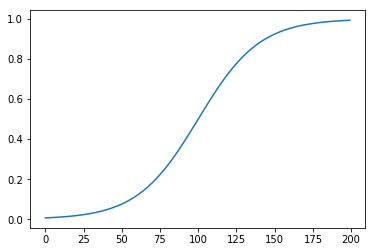

In [78]:

for i in np.arange(-100, 100):
    
    f.append(1 / (1 + exp(-0.05 * i)))

plt.plot(f)


In [147]:
from math import exp

def risk_index_en(growth_rate, npi_stringency_index, population_density, vulnerable_pop, **kwargs):
    
    raw_index =  (0.4 * growth_rate  + 0.1 * (population_density/100) + 0.2 * (vulnerable_pop/100) - 0.3 * (npi_stringency_index/100))
    
    raw_index = 100 * 1 / (1 + exp(-0.05 * raw_index))
        
    return raw_index


def risk_index_fr(growth_rate, npi_stringency_index, population_density, vulnerable_pop, **kwargs):
    
    raw_index =  (0.4 * growth_rate  + 0.1 * (population_density/100) + 0.2 * (vulnerable_pop/100) - 0.3 * (npi_stringency_index/100))
    
    raw_index = 100 * 1 / (1 + exp(-0.05 * raw_index))
        
    return raw_index


def risk_index_germ(growth_rate, npi_stringency_index, population_density, vulnerable_pop, perc_pop_chronic_diseases , **kwargs):
    
    raw_index =  (0.3 * growth_rate  + 0.1 * (population_density/100) + 0.1 * (vulnerable_pop/100) + 0.2 * (perc_pop_chronic_diseases/100) - 0.3 * (npi_stringency_index/100))
    
    raw_index = 100 * 1 / (1 + exp(-0.05 * raw_index))
        
    return raw_index
    
    


def discrete_risk_idx(risk_index):
    
    if risk_index < 20:
        
        return "0 - 20"
    
    elif risk_index < 50:
            
        return "20 - 50"
    
    elif risk_index < 70:
            
        return "50 - 70"
        
    elif risk_index < 90:
            
        return "70 - 90"
        
    else:
        
        return "90 - 100"
    
    
def process_risk_index(model, df, target, pop_stats_df, stringency_df, winsize, country_name, area_type, area_name, geo_locate, pop_density, pop_diseases):
    
    '''
    Function for processing the Risk Index. Each country having its own specificity in terms of available data sources,
    
    a different fornula is used for each country. 
    
    Inputs:
    ------
    
    
    
    Outputs:
    -------
    
    
    '''
    
    print("Predicting {} Days ahead".format(winsize))
    
    print("="*50)
        
    series = df[(df['area_name'] == area_name) & (df['area_type'] == area_type)]
    
    print("Series Shape: {}".format(series.shape))
    
    if len(series) > 0 :
        
        ## Train KF and Predict History , Predict Future

        print("Training KF and Predicting {}, {} days ahead".format(target, winsize))

        print("-"*32)

        predict_hist = model.kalman_test(series[target], winsize)

        predict_future = model.forecast(series[target], winsize, True)

        kf_predictions_all = pd.concat([predict_hist, predict_future])
        
        kf_predictions_all = kf_predictions_all[['pred', 'ci_lower', 'ci_upper', 'pred_acc', 'pred_vel']]
        
        kf_predictions_all.loc[:,'real_figures'] =  pd.Series(series[target])
        
        kf_predictions_all['country'] = country_name

        kf_predictions_all['area_name'] = series['area_name'][0]

        kf_predictions_all['area_type'] = series['area_type'][0]

        kf_predictions_all.reset_index(inplace = True)

        kf_predictions_all.rename(columns = {'index' : 'DATE'}, inplace=True)

        kf_predictions_all['DATE'] = pd.to_datetime(kf_predictions_all['DATE'], format ="%Y-%m-%d")
                
        print("Merging with Stringency and Complementary Data")

        print("-"*32)
        
        stringency_merged_df  = kf_predictions_all.merge(stringency_df, left_on = 'DATE' , right_on = 'DATE', how = 'left')
        
        print("Merging with Regional Population Data")

        print("-"*32)

        if country_name == 'Italy':
            
            if len(pop_stats_df[(pop_stats_df['area_name'] == area_name)]) > 0 :

                 stringency_merged_df['area_population_density'] = int(pop_stats_df[(pop_stats_df['area_name'] == area_name)]['All ages'])*100.00/int(pop_stats_df[pop_stats_df['area_name'] == country_name]['All ages'].values[0])
 
                 stringency_merged_df['perc_vulnerable_pop'] = 0
            
                 stringency_merged_df['perc_pop_chronic_diseases'] = 0 
    
            else:
                
                stringency_merged_df['area_population_density'] = 0 
                    
                stringency_merged_df['perc_vulnerable_pop'] = 0
            
                stringency_merged_df['perc_pop_chronic_diseases'] = 0 
                    
                 

        elif  country_name == 'France':
            
            ## One specificity in France is that the area code is not uniique, so we need to use both the area_code and area_type
            
            area_code = series[(series['area_name'] == area_name)]['area_code'][0]  
            
            if len(pop_stats_df[pop_stats_df['area_code'] == str(area_code)]) > 0:
                
                stringency_merged_df['area_population_density'] = int(pop_stats_df[(pop_stats_df['area_code']==str(area_code)) & (pop_stats_df['area_type'] == area_type)]['All ages'])*100.00/int(pop_stats_df[pop_stats_df['area_name'] == country_name]['All ages'].values[0])

                stringency_merged_df['perc_vulnerable_pop'] = int(pop_stats_df[(pop_stats_df['area_code']==str(area_code)) & (pop_stats_df['area_type'] == area_type)]['pop_above_60'])
            
                stringency_merged_df['perc_pop_chronic_diseases'] = 0 
            
            else:
                
                stringency_merged_df['area_population_density'] = 0 
                
                stringency_merged_df['perc_vulnerable_pop'] = 0
                
                stringency_merged_df['perc_pop_chronic_diseases'] = 0
                
                
        elif country_name == 'England':
            
            area_code = series[(series['area_name'] == area_name)]['area_code'][0]  
            
            if len(pop_stats_df[pop_stats_df['area_code'] == str(area_code)]) > 0:

                stringency_merged_df['area_population_density'] = int(pop_stats_df[(pop_stats_df['area_code']==str(area_code))]['All ages'])*100.00/int(pop_stats_df[pop_stats_df['area_name'] == country_name]['All ages'].values[0])      
       
                stringency_merged_df['perc_vulnerable_pop'] = int(pop_stats_df[(pop_stats_df['area_code']==str(area_code))]['pop_above_65'])*100.00/int(pop_stats_df[(pop_stats_df['area_code']==str(area_code))]['All ages'])     
                
                stringency_merged_df['perc_pop_chronic_diseases'] = 0
        
            else:

                    stringency_merged_df['area_population_density'] = 0
                    
                    stringency_merged_df['perc_vulnerable_pop'] = 0
                    
                    stringency_merged_df['perc_pop_chronic_diseases'] = 0 
        
        elif country_name == 'Germany':
            
                area_code = series[(series['area_name'] == area_name)]['area_code'][0]  
                
                if len(pop_stats_df[pop_stats_df['area_code'] == area_code]) > 0: 
            
                         stringency_merged_df['area_population_density'] = pop_density[pop_density['area_code']==area_code]['population density'].values[0]/100.0
                
                         stringency_merged_df['perc_vulnerable_pop']  =  pop_stats_df[pop_stats_df['area_code']==area_code]['pop_above_75'].values[0]*100.0/pop_stats_df[pop_stats_df['area_code']==area_code]['All-in_all'].values[0]
                    
                         stringency_merged_df['perc_pop_chronic_diseases'] = pop_diseases[pop_diseases['area_code']==area_code]['percentage'].values[0]
                        
            
                else:
                    
                    print("No Density Population Data found for: {}".format(area_name))
                    
                    stringency_merged_df['area_population_density'] = 0
                    
                    stringency_merged_df['perc_vulnerable_pop'] = 0
                    
                    stringency_merged_df['perc_pop_chronic_diseases'] = 0
        
    
        print("Extrapolating Stringency Indices and Static Data")

        print("-"*32)

        stringency_merged_df['npi_stringency_index'].fillna(method='ffill', inplace = True)

        stringency_merged_df['stats_population_density'].fillna(method='ffill', inplace = True)

        stringency_merged_df['stats_population_urban'].fillna(method='ffill', inplace = True)

        stringency_merged_df['stats_population'].fillna(method='ffill', inplace = True)

        stringency_merged_df['area_population_density'].fillna(method = 'ffill', inplace = True)

    #     stringency_merged_df['infections_var'] = stringency_merged_df['pred'].pct_change()

        print("Calculating the Risk Index")

        print("-"*32)
        
        ## Bad code, needs urgently to be optmized ..... 
        
        if country_name == 'England':  
              
                stringency_merged_df['risk_index'] = stringency_merged_df[['pred_vel', 'npi_stringency_index', 'area_population_density', 'perc_vulnerable_pop']].apply(lambda x: risk_index_en(x[0], x[1], x[2], x[3]), axis =1)

                stringency_merged_df['risk_index_disc'] = stringency_merged_df['risk_index'].apply(lambda x: discrete_risk_idx(x))

        
        elif country_name == 'France':
            
                stringency_merged_df['risk_index'] = stringency_merged_df[['pred_vel', 'npi_stringency_index', 'area_population_density', 'perc_vulnerable_pop']].apply(lambda x: risk_index_fr(x[0], x[1], x[2], x[3]), axis =1)

                stringency_merged_df['risk_index_disc'] = stringency_merged_df['risk_index'].apply(lambda x: discrete_risk_idx(x))
                
        elif country_name == 'Germany':
                
                stringency_merged_df['risk_index'] = stringency_merged_df[['pred_vel', 'npi_stringency_index', 'area_population_density', 'perc_vulnerable_pop', 'perc_pop_chronic_diseases']].apply(lambda x: risk_index_germ(x[0], x[1], x[2], x[3], x[4]), axis =1)

                stringency_merged_df['risk_index_disc'] = stringency_merged_df['risk_index'].apply(lambda x: discrete_risk_idx(x))

        
        else:
            
                stringency_merged_df['risk_index'] = stringency_merged_df[['pred_vel', 'npi_stringency_index', 'area_population_density']].apply(lambda x: risk_index(x[0], x[1], x[2]), axis =1)

                stringency_merged_df['risk_index_disc'] = stringency_merged_df['risk_index'].apply(lambda x: discrete_risk_idx(x))

            

        
#         if geo_locate:
            
#                 print("Adding Geolocation Data")

#                 print("-"*32)

#                 geolocator = Nominatim(user_agent = "my_geocoder")

#                 location = geolocator.geocode(area_name)

#                 stringency_merged_df['latitude'] = location.latitude

#                 stringency_merged_df['longitude'] = location.longitude
    
#         else:
            
#                 stringency_merged_df['latitude'] = None

#                 stringency_merged_df['longitude'] = None


        return stringency_merged_df

           

In [ ]:
## Unit Test #

# stringency_data, uk_regional_cov19, uk_regional_hle, uk_pop_stats, uk_healthcare_system = read_merge_data('England')

# kf = kalman_filter('linear', None)

# process_risk_index(kf, uk_regional_cov19, 'Cumulative lab-confirmed cases', uk_pop_stats, stringency_data, 6, 'England', 'UPPER TIER LOCAL AUTHORITY', 'Gloucestershire', False)


In [ ]:
# predictions_all = process_risk_index(kf, uk_regional_cov19, TARGET, uk_pop_stats, stringency_data, PRED_WIN, COUNTRY, 'UPPER TIER LOCAL AUTHORITY', 'Gloucestershire', GEO_LOCATE)

# predictions_all_fin = predictions_all_fin.merge(predictions_all, left_on = 'DATE', right_on = 'DATE', how = 'outer')

# predictions_all_fin.sort_values('DATE', ascending = True, inplace = True)

# predictions_all_fin.fillna(method='ffill', inplace = True)

# predictions_all_fin


In [102]:
kf = kalman_filter('linear', None)

In [103]:
## Creating a calendar Dataframe

start_date = pd.to_datetime('2020-04-01', format = "%Y-%m-%d").date()

end_date = (dt.datetime.now() + dt.timedelta(days = + 5)).date()

calendar = []

for i in range((end_date - start_date).days):
    
    calendar.append(dt.datetime.strftime(start_date + dt.timedelta(days = + i), format = "%Y-%m-%d"))
       
calendar = pd.DataFrame(calendar)

calendar.columns = ['DATE']

calendar['DATE'] = pd.to_datetime(calendar['DATE'], format = "%Y-%m-%d")


## England Prediction Loop ### 

In [132]:
%%time

COUNTRY = 'England'

TARGET = 'Cumulative lab-confirmed cases'

PRED_WIN = 5

GEO_LOCATE = False

## Reading Data

stringency_data, uk_regional_cov19, uk_regional_hle, uk_pop_stats, uk_healthcare_system = read_merge_data(COUNTRY)

# area_types_uk = uk_regional_data['Area type'].unique()

area_types_uk = ['COUNTRY', 'REGION', 'UPPER TIER LOCAL AUTHORITY']

all_areas_uk_risk_index = pd.DataFrame()

for area_type_i in area_types_uk: 
    
    uk_regional_data_i = uk_regional_cov19[uk_regional_cov19['area_type'] == area_type_i]
    
    geo_list = uk_regional_data_i['area_name'].unique()
    
    all_areas_names_uk = pd.DataFrame()
    
    for ii in geo_list:
        
        print("Generating risk index for: {} - {}".format(area_type_i, ii)) 

        predictions_all = process_risk_index(kf, uk_regional_cov19, TARGET, uk_pop_stats, stringency_data, PRED_WIN, COUNTRY, area_type_i, ii, GEO_LOCATE)
        
        predictions_all = calendar.merge(predictions_all, left_on ='DATE', right_on = 'DATE', how = 'left')
        
        predictions_all.fillna(method='ffill', inplace = True)

        all_areas_names_uk = all_areas_names_uk.append(predictions_all)
    
    all_areas_uk_risk_index = all_areas_uk_risk_index.append(all_areas_names_uk)
                

Reading Stringency Integrated Dataset for Country: England
--------------------------------
Processing UK reported cases
Found 351 area names in Dataset
--------------------------------
Reading Healthy Life Expectancy Data in EN
--------------------------------
Reading Regional Population Statistics in EN
--------------------------------
Processing Regional Population Data
-------------------------
Generating risk index for: COUNTRY - England
Predicting 5 Days ahead
Series Shape: (155, 10)
Training KF and Predicting Cumulative lab-confirmed cases, 5 days ahead
--------------------------------
Series inside smoother func: 150
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: REGION - Yorkshi

Series inside smoother func: 133
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Lewisham
Predicting 5 Days ahead
Series Shape: (113, 10)
Training KF and Predicting Cumulative lab-confirmed cases, 5 days ahead
--------------------------------
Series inside smoother func: 108
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Bradford
Pre

Series inside smoother func: 127
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Barnet
Predicting 5 Days ahead
Series Shape: (130, 10)
Training KF and Predicting Cumulative lab-confirmed cases, 5 days ahead
--------------------------------
Series inside smoother func: 125
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Wokingham
Pred

Series inside smoother func: 115
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Devon
Predicting 5 Days ahead
Series Shape: (123, 10)
Training KF and Predicting Cumulative lab-confirmed cases, 5 days ahead
--------------------------------
Series inside smoother func: 118
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Lancashire
Pred

Series inside smoother func: 131
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Warwickshire
Predicting 5 Days ahead
Series Shape: (135, 10)
Training KF and Predicting Cumulative lab-confirmed cases, 5 days ahead
--------------------------------
Series inside smoother func: 130
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Camden
P

Series inside smoother func: 112
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - North Yorkshire
Predicting 5 Days ahead
Series Shape: (130, 10)
Training KF and Predicting Cumulative lab-confirmed cases, 5 days ahead
--------------------------------
Series inside smoother func: 125
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Linco

Series inside smoother func: 118
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Southend-on-Sea
Predicting 5 Days ahead
Series Shape: (121, 10)
Training KF and Predicting Cumulative lab-confirmed cases, 5 days ahead
--------------------------------
Series inside smoother func: 116
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Luton

Series inside smoother func: 96
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Slough
Predicting 5 Days ahead
Series Shape: (118, 10)
Training KF and Predicting Cumulative lab-confirmed cases, 5 days ahead
--------------------------------
Series inside smoother func: 113
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Herefordshire, 

Series inside smoother func: 103
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Islington
Predicting 5 Days ahead
Series Shape: (114, 10)
Training KF and Predicting Cumulative lab-confirmed cases, 5 days ahead
--------------------------------
Series inside smoother func: 109
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Haringey
Pr

Series inside smoother func: 121
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Kirklees
Predicting 5 Days ahead
Series Shape: (130, 10)
Training KF and Predicting Cumulative lab-confirmed cases, 5 days ahead
--------------------------------
Series inside smoother func: 125
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Doncaster
Pr

Series inside smoother func: 122
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Solihull
Predicting 5 Days ahead
Series Shape: (111, 10)
Training KF and Predicting Cumulative lab-confirmed cases, 5 days ahead
--------------------------------
Series inside smoother func: 106
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Wakefield
Pr

Series inside smoother func: 100
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Telford and Wrekin
Predicting 5 Days ahead
Series Shape: (115, 10)
Training KF and Predicting Cumulative lab-confirmed cases, 5 days ahead
--------------------------------
Series inside smoother func: 110
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: UPPER TIER LOCAL AUTHORITY - Pe

In [133]:
all_areas_uk_risk_index[all_areas_uk_risk_index['area_name']=='Gloucestershire']

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,real_figures,country,area_name,area_type,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,area_population_density,perc_vulnerable_pop,perc_pop_chronic_diseases,risk_index,risk_index_disc
0,2020-04-01,198.979675,171.671610,226.287741,2.347802,33.483276,274.0,England,Gloucestershire,UPPER TIER LOCAL AUTHORITY,75.93,0.176,272.898,18018197.0,67886004.0,-75.0,-32.0,-29.0,-73.0,-69.0,1.131825,20.538559,0.0,65.934720,50 - 70
1,2020-04-02,237.382472,210.074511,264.690432,2.312765,35.523147,305.0,England,Gloucestershire,UPPER TIER LOCAL AUTHORITY,75.93,0.198,272.898,18018197.0,67886004.0,-75.0,-32.0,-24.0,-73.0,-70.0,1.131825,20.538559,0.0,66.845020,50 - 70
2,2020-04-03,271.727819,244.419887,299.035750,1.553606,31.163857,335.0,England,Gloucestershire,UPPER TIER LOCAL AUTHORITY,75.93,0.211,272.898,18018197.0,67886004.0,-76.0,-30.0,-25.0,-72.0,-69.0,1.131825,20.538559,0.0,64.885228,50 - 70
3,2020-04-04,303.435071,276.127145,330.742998,2.108957,37.598290,379.0,England,Gloucestershire,UPPER TIER LOCAL AUTHORITY,75.93,0.234,272.898,18018197.0,67886004.0,-81.0,-36.0,-38.0,-72.0,-57.0,1.131825,20.538559,0.0,67.758310,50 - 70
4,2020-04-05,338.476932,311.169011,365.784853,2.471508,42.893614,410.0,England,Gloucestershire,UPPER TIER LOCAL AUTHORITY,75.93,0.188,272.898,18018197.0,67886004.0,-82.0,-41.0,-29.0,-70.0,-54.0,1.131825,20.538559,0.0,70.027196,70 - 90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2020-07-21,1851.057845,1842.441570,1860.380251,-0.218369,0.596947,1849.0,England,Gloucestershire,UPPER TIER LOCAL AUTHORITY,67.13,1.511,272.898,18018197.0,67886004.0,-31.0,-10.0,85.0,-45.0,-45.0,1.131825,20.538559,0.0,50.099497,50 - 70
112,2020-07-22,1851.338121,1838.176780,1865.620565,-0.218369,0.378578,1849.0,England,Gloucestershire,UPPER TIER LOCAL AUTHORITY,67.13,1.511,272.898,18018197.0,67886004.0,-31.0,-10.0,85.0,-45.0,-45.0,1.131825,20.538559,0.0,49.990312,20 - 50
113,2020-07-23,1851.545607,1832.362032,1871.974099,-0.218369,0.160208,1849.0,England,Gloucestershire,UPPER TIER LOCAL AUTHORITY,67.13,1.511,272.898,18018197.0,67886004.0,-31.0,-10.0,85.0,-45.0,-45.0,1.131825,20.538559,0.0,49.881128,20 - 50
114,2020-07-24,1851.680303,1824.911193,1879.526985,-0.218369,-0.058161,1849.0,England,Gloucestershire,UPPER TIER LOCAL AUTHORITY,67.13,1.511,272.898,18018197.0,67886004.0,-31.0,-10.0,85.0,-45.0,-45.0,1.131825,20.538559,0.0,49.771945,20 - 50


In [ ]:
plt.plot(all_areas_uk_risk_index[all_areas_uk_risk_index['area_name']=='England']['risk_index'])

In [ ]:
plt.plot(all_areas_uk_risk_index[all_areas_uk_risk_index['area_name']=='England']['real_figures'])

In [ ]:
plt.plot(uk_regional_cov19[(uk_regional_cov19['area_name'] == 'England') & (uk_regional_cov19['area_type'] == 'COUNTRY')]['Cumulative lab-confirmed cases'])

(array([2.0000e+00, 0.0000e+00, 1.2000e+01, 1.5800e+02, 1.0359e+04,
        4.3990e+03, 1.6780e+03, 6.6500e+02, 3.8600e+02, 7.7300e+02]),
 array([  8.79407655,  17.9146689 ,  27.03526124,  36.15585359,
         45.27644593,  54.39703828,  63.51763062,  72.63822297,
         81.75881531,  90.87940766, 100.        ]),
 <a list of 10 Patch objects>)

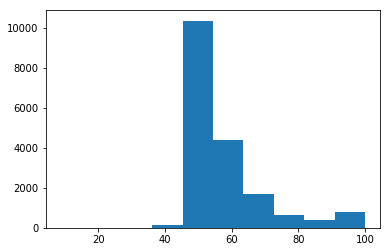

In [134]:
plt.hist(all_areas_uk_risk_index['risk_index'])

## France Prediction Loop ### 

In [135]:
fr_regional_cov19, fr_pop_stats, stringency_data, fr_icu_beds_capa = read_merge_data('France')

Reading Stringency Integrated Dataset for Country: France
--------------------------------
Reading France Official Codes
Reading Departmental Covid Cases in France
Reading Regional Covid Cases in France
Reading France Global Covid Cases
Reading Population Data
--------------------------------


In [136]:
fr_pop_stats.head()

,area_code,area_name,area_type,All ages,pop_above_60
0,84,Auvergne-Rhône-Alpes,REGION,8032377.0,26.3
1,27,Bourgogne-Franche-Comté,REGION,2783039.0,30.5
2,53,Bretagne,REGION,3340379.0,29.5
3,24,Centre-Val de Loire,REGION,2559073.0,29.6
4,94,Corse,REGION,344679.0,30.7


In [137]:
fr_regional_cov19['area_type'].unique()

array(['DEPARTEMENT', 'REGION', 'COUNTRY'], dtype=object)

In [138]:
import unicodedata

In [139]:
def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)


In [114]:
%%time

COUNTRY = 'France'

TARGET = 'Cumulative_cases'

PRED_WIN = 5

GEO_LOCATE = False

## Reading Data

fr_regional_cov19, fr_pop_stats, stringency_data, fr_icu_beds_capa = read_merge_data(COUNTRY)

area_types_fr = list(fr_regional_cov19['area_type'].unique())

all_areas_fr_risk_index = pd.DataFrame()

for area_type_i in area_types_fr: 
    
    fr_regional_data_i = fr_regional_cov19[fr_regional_cov19['area_type'] == area_type_i]
    
    geo_list = list(fr_regional_data_i['area_name'].unique())
    
    all_areas_names_fr = pd.DataFrame()
    
    for ii in geo_list:
        
        print("Generating risk index for: {} - {}".format(area_type_i, ii)) 

        predictions_all = process_risk_index(kf, fr_regional_cov19, TARGET, fr_pop_stats, stringency_data, PRED_WIN, COUNTRY, area_type_i, ii, GEO_LOCATE)
        
        predictions_all = calendar.merge(predictions_all, left_on ='DATE', right_on = 'DATE', how = 'left')
        
        predictions_all.fillna(method='ffill', inplace = True)

        all_areas_names_fr = all_areas_names_fr.append(predictions_all)
    
    all_areas_fr_risk_index = all_areas_fr_risk_index.append(all_areas_names_fr)
    


Reading Stringency Integrated Dataset for Country: France
--------------------------------
Reading France Official Codes
Reading Departmental Covid Cases in France
Reading Regional Covid Cases in France
Reading France Global Covid Cases
Reading Population Data
--------------------------------
Generating risk index for: DEPARTEMENT - Ain
Predicting 5 Days ahead
Series Shape: (66, 4)
Training KF and Predicting Cumulative_cases, 5 days ahead
--------------------------------
Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - Aisne
Predicting 5 Days ahead
Series Shape: (66, 4)
Training KF and Predicting Cumulative_cases, 5 days ahead
-----------------

Generating risk index for: DEPARTEMENT - Cantal
Predicting 5 Days ahead
Series Shape: (66, 4)
Training KF and Predicting Cumulative_cases, 5 days ahead
--------------------------------
Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - Charente
Predicting 5 Days ahead
Series Shape: (66, 4)
Training KF and Predicting Cumulative_cases, 5 days ahead
--------------------------------
Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
---------

Generating risk index for: DEPARTEMENT - Corse-du-Sud
Predicting 5 Days ahead
Series Shape: (66, 4)
Training KF and Predicting Cumulative_cases, 5 days ahead
--------------------------------
Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - Haute-Corse
Predicting 5 Days ahead
Series Shape: (66, 4)
Training KF and Predicting Cumulative_cases, 5 days ahead
--------------------------------
Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data


Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - Haute-Loire
Predicting 5 Days ahead
Series Shape: (66, 4)
Training KF and Predicting Cumulative_cases, 5 days ahead
--------------------------------
Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - Loire-Atlantique
Predicting 5 Days ahead
Series Shape: (6

Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - Moselle
Predicting 5 Days ahead
Series Shape: (66, 4)
Training KF and Predicting Cumulative_cases, 5 days ahead
--------------------------------
Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - Nièvre
Predicting 5 Days ahead
Series Shape: (66, 4)
Training

Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - Saône-et-Loire
Predicting 5 Days ahead
Series Shape: (66, 4)
Training KF and Predicting Cumulative_cases, 5 days ahead
--------------------------------
Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - Sarthe
Predicting 5 Days ahead
Series Shape: (66, 4)
T

Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - Vendée
Predicting 5 Days ahead
Series Shape: (66, 4)
Training KF and Predicting Cumulative_cases, 5 days ahead
--------------------------------
Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - Vienne
Predicting 5 Days ahead
Series Shape: (66, 4)
Training 

Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - La Réunion
Predicting 5 Days ahead
Series Shape: (66, 4)
Training KF and Predicting Cumulative_cases, 5 days ahead
--------------------------------
Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: DEPARTEMENT - Mayotte
Predicting 5 Days ahead
Series Shape: (66, 4)
Trai

Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: REGION - Bretagne
Predicting 5 Days ahead
Series Shape: (66, 4)
Training KF and Predicting Cumulative_cases, 5 days ahead
--------------------------------
Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
Generating risk index for: REGION - Nouvelle-Aquitaine
Predicting 5 Days ahead
Series Shape: (66, 4)
Train

In [115]:
all_areas_fr_risk_index['area_name'] = all_areas_fr_risk_index['area_name'].apply(lambda x: strip_accents(x) if isinstance(x, str) else x)


In [116]:
all_areas_fr_risk_index[all_areas_fr_risk_index['area_name']=='Drome']

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,real_figures,country,area_name,area_type,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,area_population_density,perc_vulnerable_pop,risk_index,risk_index_disc
52,2020-05-23,128.143513,98.908546,157.378480,0.577739,13.672902,66.0,France,Drome,DEPARTEMENT,76.85,0.475,122.578,15324817.0,65273512.0,-48.0,-14.0,-17.0,-47.0,-17.0,0.776217,28.0,56.580834,50 - 70
53,2020-05-24,136.622730,108.564960,164.680500,-0.313005,6.433352,66.0,France,Drome,DEPARTEMENT,76.85,0.517,122.578,15324817.0,65273512.0,-49.0,-17.0,21.0,-43.0,-3.0,0.776217,28.0,52.995866,50 - 70
54,2020-05-25,117.885292,90.343839,145.426745,-0.937110,0.614834,68.0,France,Drome,DEPARTEMENT,76.85,0.517,122.578,15324817.0,65273512.0,-34.0,-8.0,17.0,-46.0,-42.0,0.776217,28.0,50.090200,50 - 70
55,2020-05-26,92.282584,64.912996,119.652171,-1.581432,-6.004964,70.0,France,Drome,DEPARTEMENT,75.00,0.517,122.578,15324817.0,65273512.0,-35.0,-4.0,22.0,-44.0,-39.0,0.776217,28.0,46.791653,20 - 50
56,2020-05-27,78.662745,51.326392,105.999099,-1.346624,-5.518868,74.0,France,Drome,DEPARTEMENT,75.00,0.517,122.578,15324817.0,65273512.0,-38.0,-4.0,21.0,-43.0,-37.0,0.776217,28.0,47.033773,20 - 50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2020-07-21,398.200340,390.978986,430.591052,-1.269444,6.908768,370.0,France,Drome,DEPARTEMENT,33.33,0.757,122.578,15324817.0,65273512.0,-9.0,0.0,122.0,-17.0,-33.0,0.776217,28.0,53.395134,50 - 70
112,2020-07-22,401.972085,389.751169,444.366961,-1.269444,5.639324,370.0,France,Drome,DEPARTEMENT,33.33,0.757,122.578,15324817.0,65273512.0,-9.0,0.0,122.0,-17.0,-33.0,0.776217,28.0,52.762828,50 - 70
113,2020-07-23,401.972085,389.751169,444.366961,-1.269444,5.639324,370.0,France,Drome,DEPARTEMENT,33.33,0.757,122.578,15324817.0,65273512.0,-9.0,0.0,122.0,-17.0,-33.0,0.776217,28.0,52.762828,50 - 70
114,2020-07-24,401.972085,389.751169,444.366961,-1.269444,5.639324,370.0,France,Drome,DEPARTEMENT,33.33,0.757,122.578,15324817.0,65273512.0,-9.0,0.0,122.0,-17.0,-33.0,0.776217,28.0,52.762828,50 - 70


In [118]:
all_areas_fr_risk_index.perc_vulnerable_pop.max()

39.0

(array([  10.,   19.,   31.,   99., 2221., 3633.,  630.,  356.,  270.,
         411.]),
 array([6.35729279e-07, 1.00000006e+01, 2.00000005e+01, 3.00000004e+01,
        4.00000004e+01, 5.00000003e+01, 6.00000003e+01, 7.00000002e+01,
        8.00000001e+01, 9.00000001e+01, 1.00000000e+02]),
 <a list of 10 Patch objects>)

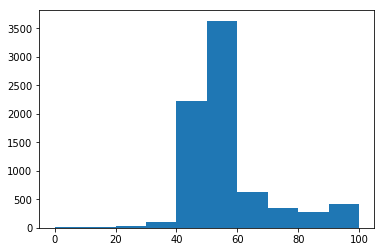

In [119]:
plt.hist(all_areas_fr_risk_index['risk_index'])

In [120]:
len(all_areas_fr_risk_index['area_name'].unique())

116

In [18]:
# area_code = fr_regional_cov19[(fr_regional_cov19['area_name'] == 'France')]['area_code'][0] 

# stringency_data['area_population_density'] = int(pop_stats_df[(pop_stats_df['area_code']==str(area_code)) & (pop_stats_df['area_type'] == area_type)]['All ages'])*100.00/int(pop_stats_df[pop_stats_df['area_name'] == country_name]['All ages'].values[0])


In [143]:
# germ_regional_cov19, germ_vulnerable_pop, germ_pop_density, germ_pop_stats, stringency_data = read_merge_data('Germany')

germ_pop_stats.head()

,area_code,pop_above_75,All-in_all,cognos name
0,1001.0,9565,90164,Kreisfreie Stadt Flensburg
1,1002.0,24653,246794,Stadt Kiel
2,1003.0,27915,216530,Hansestadt Luebeck
3,1004.0,9884,80196,Kreisfreie Stadt Neumünster
4,1051.0,17171,133193,Landkreis Dithmarschen


## Germany Prediction Loop ###

In [148]:
%%time

COUNTRY = 'Germany'

TARGET = 'cum cases'

PRED_WIN = 5

GEO_LOCATE = False 
    

## Reading Data

germ_regional_cov19, germ_vulnerable_pop, germ_pop_density, germ_pop_stats, stringency_data = read_merge_data(COUNTRY)

# area_types_germ = list(germ_regional_cov19['area_type'].unique())

area_types_germ = list(germ_regional_cov19['area_type'].unique())

all_areas_germ_risk_index = pd.DataFrame()

for area_type_i in area_types_germ: 
    
    germ_regional_data_i = germ_regional_cov19[germ_regional_cov19['area_type'] == area_type_i]
    
    geo_list = list(germ_regional_data_i['area_name'].unique())
    
    all_areas_names_germ = pd.DataFrame()
    
    for ii in geo_list:
        
        print("Generating risk index for: {} - {}".format(area_type_i, ii))

        predictions_all = process_risk_index(kf, germ_regional_cov19, TARGET, germ_pop_stats, stringency_data, PRED_WIN, COUNTRY, area_type_i, ii, GEO_LOCATE, germ_pop_density, germ_vulnerable_pop)
        
        predictions_all = calendar.merge(predictions_all, left_on = 'DATE', right_on = 'DATE', how = 'left')
        
        predictions_all.fillna(method = 'ffill', inplace = True)

        all_areas_names_germ = all_areas_names_germ.append(predictions_all)
        
        print('all_areas_names_germ contains the following areas: {}'.format(all_areas_names_germ['area_name'].unique()))
    
    all_areas_germ_risk_index = all_areas_germ_risk_index.append(all_areas_names_germ)
    
    print('all_areas_germ_risk_index contains the following areas: {}'.format(all_areas_germ_risk_index['area_name'].unique()))

all_areas_germ_risk_index.dropna(subset = ['area_name'], inplace = True)
                

Reading Stringency Integrated Dataset for Country: Germany
--------------------------------
Reading Covid 19 and Other complementary Data
--------------------------------
Generating risk index for: Landkreis - Berlin, Stadt
Predicting 5 Days ahead
Series Shape: (138, 5)
Training KF and Predicting cum cases, 5 days ahead
--------------------------------
Series inside smoother func: 133
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt']
Generating risk index for: Landkreis - Landkreis Ahrweiler
Predicting 5 Days ahead
Series Shape: (73, 5)
Training KF and Predicting cum cases, 5 days ahead
--------------------------------
Series inside smoother func: 6

Series inside smoother func: 51
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland']
Generating risk index for: Landkreis - Landkreis Anhalt-Bitterfeld
Predicting 5 Days ahead
Series Shape: (31, 5)
Training KF and Predicting cum cases, 5 days ahead
--------------------------------
Series inside smoother func: 26
Series inside smoother func: 5
Merging with Stringency and C

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach']
Generating risk index for: Landkreis - Landkreis Bad Tölz-Wolfratshausen
Predicting 5 Days ahead
Series Shape: (72, 5)
Training KF and Predicting cum cases, 5 days ahead
--------------------------------
Series inside smoother func: 67
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indice

Series inside smoother func: 74
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 94
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 64
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 80
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 73
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Series inside smoother func: 61
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 99
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 63
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 81
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series Shape: (79, 5)
Training KF and Predicting cum cases, 5 days ahead
--------------------------------
Series inside smoother func: 74
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Ba

Series inside smoother func: 53
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 67
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 80
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 44
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 75
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 58
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 90
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 77
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkr

Series inside smoother func: 69
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 40
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 68
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 66
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 60
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodense

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Series inside smoother func: 103
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 77
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böbl

Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burge

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 112
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 70
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 49
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 94
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 107
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 72
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 62
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 50
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 66
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 111
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 72
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 93
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-H

Series inside smoother func: 81
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 70
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 117
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 77
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 99
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 113
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 102
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 108
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkr

Series inside smoother func: 94
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burge

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 73
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 76
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 82
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 87
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-H

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 88
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 105
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 49
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkr

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 83
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burge

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 113
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkr

Series inside smoother func: 126
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 120
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 58
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 85
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 123
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 83
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Series inside smoother func: 97
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 92
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittli

Series inside smoother func: 130
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkr

Series inside smoother func: 90
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodense

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Series inside smoother func: 91
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 132
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkr

Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkr

Series inside smoother func: 77
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 90
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Series inside smoother func: 82
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 109
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 134
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 84
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 104
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 78
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 96
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böbl

--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böbl

Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkr

Series inside smoother func: 112
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodense

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 94
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkr

Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Lan

Series inside smoother func: 105
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

Series inside smoother func: 62
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautze

all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'Landkr

Series inside smoother func: 107
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautz

all_areas_germ_risk_index contains the following areas: ['Berlin, Stadt' 'Landkreis Ahrweiler' 'Landkreis Aichach-Friedberg'
 'Landkreis Alb-Donau-Kreis' 'Landkreis Altenburger Land'
 'Landkreis Altenkirchen (Westerwald)' nan
 'Landkreis Altmarkkreis Salzwedel' 'Landkreis Altötting'
 'Landkreis Alzey-Worms' 'Landkreis Amberg-Sulzbach' 'Landkreis Ammerland'
 'Landkreis Anhalt-Bitterfeld' 'Landkreis Ansbach'
 'Landkreis Aschaffenburg' 'Landkreis Augsburg' 'Landkreis Aurich'
 'Landkreis Bad Dürkheim' 'Landkreis Bad Kissingen'
 'Landkreis Bad Kreuznach' 'Landkreis Bad Tölz-Wolfratshausen'
 'Landkreis Bamberg' 'Landkreis Barnim' 'Landkreis Bautzen'
 'Landkreis Bayreuth' 'Landkreis Berchtesgadener Land'
 'Landkreis Bergstraße' 'Landkreis Bernkastel-Wittlich'
 'Landkreis Biberach' 'Landkreis Birkenfeld'
 'Landkreis Eifelkreis Bitburg-Prüm' 'Landkreis Bodenseekreis'
 'Landkreis Borken' 'Landkreis Breisgau-Hochschwarzwald'
 'Landkreis Burgenlandkreis' 'Landkreis Böblingen' 'Landkreis Börde'
 'L

Series inside smoother func: 140
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
No Density Population Data found for: Baden-Württemberg
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Baden-Württemberg']
Generating risk index for: Bundesland - Bayern
Predicting 5 Days ahead
Series Shape: (151, 5)
Training KF and Predicting cum cases, 5 days ahead
--------------------------------
Series inside smoother func: 146
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
No Density Population Data found for: Bayern
Extrapolating Stringency Indices and Static Data
---------------------------

Series inside smoother func: 122
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
No Density Population Data found for: Sachsen
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_germ contains the following areas: ['Baden-Württemberg' 'Bayern' 'Brandenburg' 'Bremen' 'Hamburg' 'Hessen'
 'Mecklenburg-Vorpommern' 'Niedersachsen' 'Nordrhein-Westfalen'
 'Rheinland-Pfalz' 'Saarland' 'Sachsen']
Generating risk index for: Bundesland - Sachsen-Anhalt
Predicting 5 Days ahead
Series Shape: (120, 5)
Training KF and Predicting cum cases, 5 days ahead
--------------------------------
Series inside smoother func: 115
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
-

CPU times: user 4min 27s, sys: 2.48 s, total: 4min 29s
Wall time: 2min 54s


In [129]:
# germ_pop_stats[germ_pop_stats['area_code']==1001.0]['pop_above_75'].values[0]*100.0/germ_pop_stats[germ_pop_stats['area_code']==1001]['All-in_all'].values[0]

10.608446830220487

(array([6.0000e+00, 6.0000e+00, 1.6000e+01, 1.0000e+02, 1.5214e+04,
        3.0779e+04, 1.2490e+03, 3.1800e+02, 1.8600e+02, 2.1400e+02]),
 array([9.41400221e-02, 1.00847260e+01, 2.00753120e+01, 3.00658980e+01,
        4.00564840e+01, 5.00470700e+01, 6.00376560e+01, 7.00282420e+01,
        8.00188280e+01, 9.00094140e+01, 1.00000000e+02]),
 <a list of 10 Patch objects>)

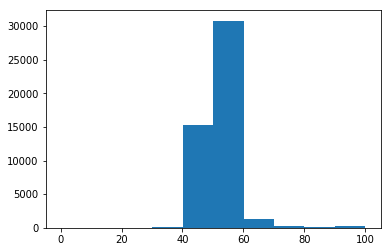

In [149]:
plt.hist(all_areas_germ_risk_index['risk_index'])

In [150]:
all_areas_germ_risk_index.head()

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,real_figures,country,area_name,area_type,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,area_population_density,perc_vulnerable_pop,perc_pop_chronic_diseases,risk_index,risk_index_disc
0,2020-04-01,2929.342517,2902.034596,2956.650438,21.850417,376.020424,3088.0,Germany,"Berlin, Stadt",Landkreis,73.15,NaN,237.016,7977060.0,83783945.0,-52.0,-13.0,20.0,-53.0,-43.0,40.55,10.342879,22.2,99.643883,90 - 100
1,2020-04-02,3300.595107,3273.287194,3327.903019,13.895691,327.958911,3325.0,Germany,"Berlin, Stadt",Landkreis,73.15,NaN,237.016,7977060.0,83783945.0,-54.0,-11.0,6.0,-54.0,-43.0,40.55,10.342879,22.2,99.270450,90 - 100
2,2020-04-03,3538.176092,3510.868188,3565.483996,-5.231364,173.752093,3564.0,Germany,"Berlin, Stadt",Landkreis,73.15,NaN,237.016,7977060.0,83783945.0,-57.0,-11.0,-13.0,-57.0,-44.0,40.55,10.342879,22.2,93.086631,90 - 100
3,2020-04-04,3634.930221,3607.622321,3662.238120,-14.507344,86.996649,3672.0,Germany,"Berlin, Stadt",Landkreis,73.15,NaN,237.016,7977060.0,83783945.0,-63.0,-16.0,21.0,-52.0,-31.0,40.55,10.342879,22.2,78.562317,70 - 90
4,2020-04-05,3631.164740,3603.856842,3658.472637,-12.062141,93.979527,3750.0,Germany,"Berlin, Stadt",Landkreis,73.15,NaN,237.016,7977060.0,83783945.0,-58.0,-13.0,61.0,-47.0,-30.0,40.55,10.342879,22.2,80.273633,70 - 90


In [ ]:
# germ_cov_cases = pd.read_csv("/project_data/data_asset/df_pipeline_germany.csv")

# germ_cov_cases.rename(columns = {'Cognos Area name': 'area_name', 'Area type': 'area_type', 'Cca 2': 'area_code'}, inplace = True)

# germ_cov_cases = germ_cov_cases[['area_name', 'area_type', 'area_code', 'Country', 'cum cases']]


In [151]:
all_areas_germ_risk_index[all_areas_germ_risk_index['area_name'].str.contains('Baden-Württemberg')]

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,real_figures,country,area_name,area_type,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,area_population_density,perc_vulnerable_pop,perc_pop_chronic_diseases,risk_index,risk_index_disc
0,2020-04-01,14914.874721,14887.566824,14942.182617,115.484888,1932.025931,16581.0,Germany,Baden-Württemberg,Bundesland,73.15,NaN,237.016,7977060.0,83783945.0,-52.0,-13.0,20.0,-53.0,-43.0,0.0,0.0,0.0,100.000000,90 - 100
1,2020-04-02,16961.816258,16934.508362,16989.124154,81.279194,1746.886254,18004.0,Germany,Baden-Württemberg,Bundesland,73.15,NaN,237.016,7977060.0,83783945.0,-54.0,-11.0,6.0,-54.0,-43.0,0.0,0.0,0.0,100.000000,90 - 100
2,2020-04-03,18340.927180,18313.619284,18368.235076,3.278640,1142.639743,19275.0,Germany,Baden-Württemberg,Bundesland,73.15,NaN,237.016,7977060.0,83783945.0,-57.0,-11.0,-13.0,-57.0,-44.0,0.0,0.0,0.0,99.999996,90 - 100
3,2020-04-04,19058.498503,19031.190607,19085.806399,-41.210829,754.912514,20129.0,Germany,Baden-Württemberg,Bundesland,73.15,NaN,237.016,7977060.0,83783945.0,-63.0,-16.0,21.0,-52.0,-31.0,0.0,0.0,0.0,99.998778,90 - 100
4,2020-04-05,19493.757927,19466.450031,19521.065823,-29.721457,814.678660,20624.0,Germany,Baden-Württemberg,Bundesland,73.15,NaN,237.016,7977060.0,83783945.0,-58.0,-13.0,61.0,-47.0,-30.0,0.0,0.0,0.0,99.999502,90 - 100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2020-07-21,36465.675803,36519.173952,36558.786019,1.109956,50.164403,36342.0,Germany,Baden-Württemberg,Bundesland,39.35,NaN,237.016,7977060.0,83783945.0,-6.0,-2.0,108.0,-21.0,-28.0,0.0,0.0,0.0,67.842945,50 - 70
112,2020-07-22,36490.480515,36562.391471,36617.007263,1.109956,51.274359,36342.0,Germany,Baden-Württemberg,Bundesland,39.35,NaN,237.016,7977060.0,83783945.0,-6.0,-2.0,108.0,-21.0,-28.0,0.0,0.0,0.0,68.205088,50 - 70
113,2020-07-23,36490.480515,36562.391471,36617.007263,1.109956,51.274359,36342.0,Germany,Baden-Württemberg,Bundesland,39.35,NaN,237.016,7977060.0,83783945.0,-6.0,-2.0,108.0,-21.0,-28.0,0.0,0.0,0.0,68.205088,50 - 70
114,2020-07-24,36490.480515,36562.391471,36617.007263,1.109956,51.274359,36342.0,Germany,Baden-Württemberg,Bundesland,39.35,NaN,237.016,7977060.0,83783945.0,-6.0,-2.0,108.0,-21.0,-28.0,0.0,0.0,0.0,68.205088,50 - 70


In [ ]:
# all_areas_germ_risk_index.dropna(subset = ['area_name'], inplace = True)

# all_areas_germ_risk_index[all_areas_germ_risk_index['area_name']=='Kreisfreie Stadt Koln']

In [154]:
italy_data_all_areas, ita_pop_data, stringency_data = read_merge_data('Italy')

italy_data_all_areas.head()

Reading Stringency Integrated Dataset for Country: Italy
--------------------------------
Reading Covid Cases Data in Italy
--------------------------------
The dataset contains 568 duplicates


,Cum_cases,area_code,area_name,area_type
date,,,,
2020-02-24,229,None,Italy,Country
2020-02-25,322,None,Italy,Country
2020-02-26,400,None,Italy,Country
2020-02-27,650,None,Italy,Country
2020-02-28,888,None,Italy,Country


In [152]:
ita_pop_data.head()

,area_name,All ages
5,Italy,60359546
11,Nord-ovest,16093286
17,Piemonte,4356406
23,Torino,2259523
29,Vercelli,170911


## Italy Prediction Loop

In [155]:
%%time

COUNTRY = 'Italy'

TARGET = 'Cum_cases'

PRED_WIN = 5

GEO_LOCATE = False

## Reading Data

ita_regional_cov19, ita_pop_data, stringency_data = read_merge_data(COUNTRY)

# area_types_germ = list(germ_regional_cov19['area_type'].unique())

area_types_ita = list(ita_regional_cov19['area_type'].unique())

all_areas_ita_risk_index = pd.DataFrame()

for area_type_i in area_types_ita: 
    
    ita_regional_data_i = ita_regional_cov19[ita_regional_cov19['area_type'] == area_type_i]
    
    geo_list = list(ita_regional_data_i['area_name'].unique())
    
    all_areas_names_ita = pd.DataFrame()
    
    for ii in geo_list:
        
        print("Generating risk index for: {} - {}".format(area_type_i, ii))

        predictions_all = process_risk_index(kf, ita_regional_cov19, TARGET, ita_pop_data, stringency_data, PRED_WIN, COUNTRY, area_type_i, ii, GEO_LOCATE, None, None)
        
        predictions_all = calendar.merge(predictions_all, left_on = 'DATE', right_on = 'DATE', how = 'left')
        
        predictions_all.fillna(method = 'ffill', inplace = True)

        all_areas_names_ita = all_areas_names_ita.append(predictions_all)
        
        print('all_areas_names_ita contains the following areas: {}'.format(all_areas_names_ita['area_name'].unique()))
    
    all_areas_ita_risk_index = all_areas_ita_risk_index.append(all_areas_names_ita)
    
    print('all_areas_ita_risk_index contains the following areas: {}'.format(all_areas_ita_risk_index['area_name'].unique()))

all_areas_ita_risk_index.dropna(subset = ['area_name'], inplace = True)
                

Reading Stringency Integrated Dataset for Country: Italy
--------------------------------
Reading Covid Cases Data in Italy
--------------------------------
The dataset contains 568 duplicates
Generating risk index for: Country - Italy
Predicting 5 Days ahead
Series Shape: (148, 4)
Training KF and Predicting Cum_cases, 5 days ahead
--------------------------------
Series inside smoother func: 143
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_ita contains the following areas: ['Italy']
all_areas_ita_risk_index contains the following areas: ['Italy']
Generating risk index for: Region - Abruzzo
Predicting 5 Days ahead
Series Shape: (127, 4)
Training KF and Predicting Cum_cases, 5 days ahead
---------

Series inside smoother func: 68
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_ita contains the following areas: ['Abruzzo' 'Basilicata' 'Calabria' 'Campania' 'Emilia-Romagna'
 'Friuli Venezia Giulia' 'Lazio' 'Liguria' 'Lombardia' 'Marche' 'Molise']
Generating risk index for: Region - P.A. Bolzano
Predicting 5 Days ahead
Series Shape: (111, 4)
Training KF and Predicting Cum_cases, 5 days ahead
--------------------------------
Series inside smoother func: 106
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
-------------

Series inside smoother func: 142
Series inside smoother func: 5
Merging with Stringency and Complementary Data
--------------------------------
Merging with Regional Population Data
--------------------------------
Extrapolating Stringency Indices and Static Data
--------------------------------
Calculating the Risk Index
--------------------------------
all_areas_names_ita contains the following areas: ['Abruzzo' 'Basilicata' 'Calabria' 'Campania' 'Emilia-Romagna'
 'Friuli Venezia Giulia' 'Lazio' 'Liguria' 'Lombardia' 'Marche' 'Molise'
 'P.A. Bolzano' 'P.A. Trento' 'Piemonte' 'Puglia' 'Sardegna' 'Sicilia'
 'Toscana' 'Umbria' "Valle d'Aosta" 'Veneto']
all_areas_ita_risk_index contains the following areas: ['Italy' 'Abruzzo' 'Basilicata' 'Calabria' 'Campania' 'Emilia-Romagna'
 'Friuli Venezia Giulia' 'Lazio' 'Liguria' 'Lombardia' 'Marche' 'Molise'
 'P.A. Bolzano' 'P.A. Trento' 'Piemonte' 'Puglia' 'Sardegna' 'Sicilia'
 'Toscana' 'Umbria' "Valle d'Aosta" 'Veneto']
CPU times: user 11.2 s, 

(array([ 42.,  16.,  32.,  63., 428., 824., 220., 132., 142., 653.]),
 array([5.03002866e-06, 1.00000045e+01, 2.00000040e+01, 3.00000035e+01,
        4.00000030e+01, 5.00000025e+01, 6.00000020e+01, 7.00000015e+01,
        8.00000010e+01, 9.00000005e+01, 1.00000000e+02]),
 <a list of 10 Patch objects>)

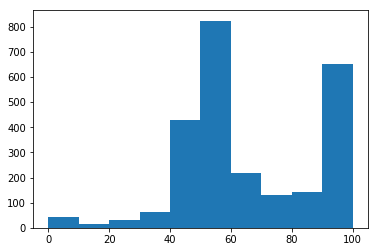

In [156]:
plt.hist(all_areas_ita_risk_index['risk_index'])

# Neighbours Dataset

In [ ]:
uk_neighbours = pd.read_csv('/project_data/data_asset/df_uk_neighbours_processed.csv')

uk_neighbours.head()

In [ ]:
uk_neighbours[uk_neighbours['me_name']=='Dorset']

## Saving Data to COS

In [157]:
## Merging Datasets

risk_index_df_final = pd.concat([all_areas_uk_risk_index, all_areas_fr_risk_index, all_areas_ita_risk_index], axis = 0)

risk_index_df_final.shape

(34916, 25)

In [158]:
risk_index_df_final.head()

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,real_figures,country,area_name,area_type,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,area_population_density,perc_vulnerable_pop,perc_pop_chronic_diseases,risk_index,risk_index_disc
0,2020-04-01,29995.617609,29968.309713,30022.925504,272.366201,4294.864451,36851.0,England,England,COUNTRY,75.93,0.176,272.898,18018197.0,67886004.0,-75.0,-32.0,-29.0,-73.0,-69.0,100.0,17.475527,0.0,100.0,90 - 100
1,2020-04-02,33906.907660,33879.599764,33934.215556,206.921380,3992.053874,40923.0,England,England,COUNTRY,75.93,0.198,272.898,18018197.0,67886004.0,-75.0,-32.0,-24.0,-73.0,-70.0,100.0,17.475527,0.0,100.0,90 - 100
2,2020-04-03,37130.398646,37103.090750,37157.706542,127.554822,3501.444116,45024.0,England,England,COUNTRY,75.93,0.211,272.898,18018197.0,67886004.0,-76.0,-30.0,-25.0,-72.0,-69.0,100.0,17.475527,0.0,100.0,90 - 100
3,2020-04-04,40393.867458,40366.559562,40421.175354,155.844501,3877.629253,48415.0,England,England,COUNTRY,75.93,0.234,272.898,18018197.0,67886004.0,-81.0,-36.0,-38.0,-72.0,-57.0,100.0,17.475527,0.0,100.0,90 - 100
4,2020-04-05,44012.224238,43984.916342,44039.532134,221.575816,4611.168443,51499.0,England,England,COUNTRY,75.93,0.188,272.898,18018197.0,67886004.0,-82.0,-41.0,-29.0,-70.0,-54.0,100.0,17.475527,0.0,100.0,90 - 100


In [25]:
all_areas_fr_risk_index[all_areas_fr_risk_index['area_name'] == 'Drome']

,DATE,pred,ci_lower,ci_upper,pred_acc,pred_vel,real_figures,country,area_name,area_type,npi_stringency_index,tests_new_per_thousand,stats_population_density,stats_population_urban,stats_population,mobility_retail_recreation,mobility_grocery_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,area_population_density,risk_index,risk_index_disc
52,2020-05-23,128.143513,98.908546,157.378480,0.577739,13.672902,66.0,France,Drome,DEPARTEMENT,76.85,0.475,122.578,15324817.0,65273512.0,-48.0,-14.0,-17.0,-47.0,-17.0,0.776217,65.942780,50 - 70
53,2020-05-24,136.622730,108.564960,164.680500,-0.313005,6.433352,66.0,France,Drome,DEPARTEMENT,76.85,0.517,122.578,15324817.0,65273512.0,-49.0,-17.0,21.0,-43.0,-3.0,0.776217,57.414128,50 - 70
54,2020-05-25,117.885292,90.343839,145.426745,-0.937110,0.614834,68.0,France,Drome,DEPARTEMENT,76.85,0.517,122.578,15324817.0,65273512.0,-34.0,-8.0,17.0,-46.0,-42.0,0.776217,50.196048,50 - 70
55,2020-05-26,92.282584,64.912996,119.652171,-1.581432,-6.004964,70.0,France,Drome,DEPARTEMENT,75.00,0.517,122.578,15324817.0,65273512.0,-35.0,-4.0,22.0,-44.0,-39.0,0.776217,42.004395,20 - 50
56,2020-05-27,78.662745,51.326392,105.999099,-1.346624,-5.518868,74.0,France,Drome,DEPARTEMENT,75.00,0.517,122.578,15324817.0,65273512.0,-38.0,-4.0,21.0,-43.0,-37.0,0.776217,42.597601,20 - 50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,2020-07-20,394.005447,389.519637,416.963421,-1.269444,8.178212,370.0,France,Drome,DEPARTEMENT,33.33,0.757,122.578,15324817.0,65273512.0,-29.0,-39.0,208.0,-39.0,-76.0,0.776217,59.846344,50 - 70
111,2020-07-21,398.200340,390.978986,430.591052,-1.269444,6.908768,370.0,France,Drome,DEPARTEMENT,33.33,0.757,122.578,15324817.0,65273512.0,-29.0,-39.0,208.0,-39.0,-76.0,0.776217,58.312001,50 - 70
112,2020-07-22,401.972085,389.751169,444.366961,-1.269444,5.639324,370.0,France,Drome,DEPARTEMENT,33.33,0.757,122.578,15324817.0,65273512.0,-29.0,-39.0,208.0,-39.0,-76.0,0.776217,56.761389,50 - 70
113,2020-07-23,401.972085,389.751169,444.366961,-1.269444,5.639324,370.0,France,Drome,DEPARTEMENT,33.33,0.757,122.578,15324817.0,65273512.0,-29.0,-39.0,208.0,-39.0,-76.0,0.776217,56.761389,50 - 70


In [161]:
from project_lib import Project

project = Project.access()

project.save_data(file_name = "risk_index_df_final.csv", data = risk_index_df_final.to_csv(index = False), overwrite = True)


{'file_name': 'risk_index_df_final.csv',
 'message': 'File saved to project storage.',
 'asset_id': '031614ad-bd32-4265-ae24-7d446e787d58'}

In [162]:
project = Project.access()

project.save_data(file_name = "all_areas_germ_risk_index.csv", data = all_areas_germ_risk_index.to_csv(index = False), overwrite = True)


{'file_name': 'all_areas_germ_risk_index.csv',
 'message': 'File saved to project storage.',
 'asset_id': '376fb530-d4af-4033-a54c-b059e1c6175f'}

In [44]:
risk_index_df_final.DATE.max()

Timestamp('2020-07-24 00:00:00')